In [1]:
!nvidia-smi

Fri May 21 07:57:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    22W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%pip install -q tensorflow-addons[tensorflow]
%pip install -q simpleitk
# %pip install -q colab_ssh
%pip install -q wandb

     |████████████████████████████████| 686kB 14.2MB/s 
     |████████████████████████████████| 47.4MB 103kB/s 
     |████████████████████████████████| 1.8MB 14.7MB/s 
     |████████████████████████████████| 102kB 13.1MB/s 
     |████████████████████████████████| 133kB 49.2MB/s 
     |████████████████████████████████| 174kB 53.1MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 


In [3]:
!gdown https://drive.google.com/uc?id=1jYb-dKqywLm5bQ5esP6YSV5xuBzqBPqm

Downloading...
From: https://drive.google.com/uc?id=1jYb-dKqywLm5bQ5esP6YSV5xuBzqBPqm
To: /content/BRATS_Dataset.tar.gz
2.76GB [00:43, 62.9MB/s]


In [4]:
!apt -qq install pigz

The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  pigz
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 57.4 kB of archives.
After this operation, 259 kB of additional disk space will be used.
Selecting previously unselected package pigz.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../archives/pigz_2.4-1_amd64.deb ...
Unpacking pigz (2.4-1) ...
Setting up pigz (2.4-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [5]:
!pigz -dc BRATS_Dataset.tar.gz | tar xf -

In [6]:
!rm BRATS_Dataset.tar.gz

In [2]:
%cd /content
!rm -rf 3D_res_attn_Unet

/content


In [3]:
!git clone https://github.com/ShivamShrirao/3D_res_attn_Unet

Cloning into '3D_res_attn_Unet'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 144 (delta 97), reused 89 (delta 42), pack-reused 0
Receiving objects: 100% (144/144), 523.27 KiB | 7.58 MiB/s, done.
Resolving deltas: 100% (97/97), done.


In [4]:
%cd 3D_res_attn_Unet

/content/3D_res_attn_Unet


In [5]:
%load_ext tensorboard
%load_ext autoreload
%autoreload 2

In [6]:
import SimpleITK as sitk

In [7]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import glob
from tqdm.notebook import tqdm
from time import time
%matplotlib inline

In [8]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-SXM2-16GB, compute capability 7.0
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


In [9]:
def get_data_paths(dataset_path):
    t1 = glob.glob(dataset_path+'/*GG/*/*t1.nii.gz')
    t2 = glob.glob(dataset_path+'/*GG/*/*t2.nii.gz')
    t1ce = glob.glob(dataset_path+'/*GG/*/*t1ce.nii.gz')
    flair = glob.glob(dataset_path+'/*GG/*/*flair.nii.gz')
    seg = glob.glob(dataset_path+'/*GG/*/*seg.nii.gz')
    return list(zip(t1, t2, t1ce, flair, seg))

In [10]:
train_paths = get_data_paths('../BRATS_Dataset/brats_dataset/')
val_paths = get_data_paths('../BRATS_Dataset/brats_test_dataset/')

In [11]:
len(train_paths), len(val_paths)

(285, 50)

In [12]:
from model.preprocess import *

In [13]:
mean = tf.constant([0.06301811, 0.05202341, 0.04396216, 0.05345017], shape=(1, 4, 1, 1, 1))
std  = tf.constant([0.14905235, 0.12771605, 0.1042005 , 0.12938198], shape=(1, 4, 1, 1, 1))

In [14]:
# mean = []
# std = []
# for tp in tqdm(train_paths[0:100]):
#     img, lbl = load_img(tp)
#     img = tf.cast(img, tf.float32)/255.0
#     mean.append(tf.reduce_mean(img, axis=[1,2,3]))
#     std.append(tf.math.reduce_std(img, axis=[1,2,3]))
# mean = tf.reshape(tf.reduce_mean(mean, axis=0), (1, 4, 1, 1, 1))
# std = tf.reshape(tf.reduce_mean(std, axis=0), (1, 4, 1, 1, 1))

In [15]:
depth = 128 # 155
height = 192 # 240
width = 160 # 240
(155-depth, 240-height, 240-width)

(27, 48, 80)

In [16]:
def random_crop3D(imgs, lbls, train=True):          # Crops image to size (128, 192, 160)
    d_cr, h_cr, w_cr = 13, 24, 40
    if train:
        if tf.random.uniform([], 0, 1, dtype=tf.float32) <= 0.8:
            d_cr = tf.random.uniform([], 0, 27, dtype=tf.int32)
            h_cr = tf.random.uniform([], 0, 48, dtype=tf.int32)
            w_cr = tf.random.uniform([], 0, 80, dtype=tf.int32)
    imgs = imgs[:, :, d_cr:d_cr+depth, h_cr:h_cr+height, w_cr:w_cr+width]
    lbls = lbls[:, :, d_cr:d_cr+depth, h_cr:h_cr+height, w_cr:w_cr+width]
    return imgs, lbls

In [17]:
def final_augmentation(imgs, lbls, train=True):       # input imgs[B, 4, 155, 240, 240], output[B, 4, 128, 192, 160]
    imgs, lbls = random_crop3D(imgs, lbls, train)
    imgs = tf.cast(imgs, tf.float32)/255.0
    lbls = tf.cast(lbls, tf.float32)
    if train:
        imgs = tf.image.random_brightness(imgs, 0.2)      # source code checked, it's fine for 3D
    # imgs = tf.image.per_image_standardization(imgs)   # source code checked, it's fine for 3D
    imgs = (imgs - mean) / std
    return imgs, lbls

In [18]:
BATCH_SIZE = 2
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [19]:
def get_tfds(data_paths, train=False):
    # 53.3373920917511 s
    dataset = tf.data.Dataset.from_tensor_slices(data_paths)
    if train:
        dataset = dataset.shuffle(len(data_paths))
    dataset = dataset.map(load_paths_wrapper, num_parallel_calls=AUTOTUNE)
    if train:
        dataset = dataset.map(random_rotate3D, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    if train:
        dataset = dataset.map(random_flip3D, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(lambda x,y: final_augmentation(x,y,train), num_parallel_calls=AUTOTUNE)      # remove for test,val
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [20]:
train_ds = get_tfds(train_paths, train=True)
val_ds = get_tfds(val_paths)

In [21]:
import wandb
from wandb.keras import WandbCallback

In [22]:
wandb.login()

wandb: Currently logged in as: shivamshrirao (use `wandb login --relogin` to force relogin)


True

In [23]:
config_defaults = {
    'activation'            : 'leaky_relu',
    'batch_size'            : BATCH_SIZE,
    'block_type'            : 'AttnBottleneckBlock',
    'clr_step_size'         : 10,
    'clr_offset_ep'         : 7,
    'groups'                : 32,
    'dp_rate'               : 0.22,
    'dropout_type'          : 'Spatial',
    'frac_dv'               : 0.5,
    'loss_function'         : 'FocalTversky',
    'max_lr'                : 6e-4,
    'min_lr'                : 1e-6,
    'nheads'                : 8,
    'norm'                  : 'gn',
    'optimizer'             : 'adamw',
    'vary_weight_decay'     : True,
    'weight_decay'          : 4e-5,     # max weight decay
}
CONFIG = config_defaults

In [24]:
# run = wandb.init(id='sxeicdk0', project="3D_res_attn_Unet", resume='must')
# CONFIG = run.config

In [60]:
run = wandb.init(project="3D_res_attn_Unet", entity="shivamshrirao", config=config_defaults)
CONFIG = wandb.config

In [25]:
mean.numpy().ravel(), std.numpy().ravel()

(array([0.06301811, 0.05202341, 0.04396216, 0.05345017], dtype=float32),
 array([0.14905235, 0.12771605, 0.1042005 , 0.12938198], dtype=float32))

In [26]:
tf.keras.backend.set_image_data_format('channels_first')

In [27]:
## attention shortcuts to be used.
## try attention on the unet shortcuts
## try Global Context Block
## try input image pyramid and deep supervised output layers (output from intermediate layers (fuse with conv-sigmoid like U^2net ??))
## TRY PIXELSHUFFLE
## Try SPARSE CONV NET https://github.com/facebookresearch/SparseConvNet

In [28]:
from model.conv_blocks import *

In [26]:
def enc_dec(x, block, frac_dv, stack_args):     # x(64,64,96,80)
    x1 = down_stack(x ,  64, nblocks=2, block=block, strides=2, **stack_args)     # (256,32,48,40)
    x2 = down_stack(x1, 128, nblocks=2, block=block, strides=2, **stack_args)     # (512,16,24,20)
    x3 = down_stack(x2, 256, nblocks=2, block=block, strides=2, frac_dv=frac_dv, **stack_args) # (1024, 8,12,10)
    x4 = down_stack(x3, 256, nblocks=3, block=block, strides=2, frac_dv=frac_dv, **stack_args) # (1024, 4, 6, 5)

    y = up_stack(x4,x3, 128, nblocks=3, block=block, strides=2, frac_dv=frac_dv, **stack_args) # (1024+1024->512,8,12,10)
    y = up_stack(y, x2,  64, nblocks=2, block=block, strides=2, **stack_args)     # (512+512->256,16,24,20)
    y = up_stack(y, x1,  32, nblocks=2, block=block, strides=2, **stack_args)     # (256+256->128,32,48,40)
    y = up_stack(y, x ,  16, nblocks=1, block=block, strides=2, **stack_args)     # (128+ 64-> 64,64,96,80)
    return y


def build_network(cfg, block, input_shape=(4,128,192,160), classes=4):
    stack_args = {'activation': cfg['activation'], 'groups': cfg['groups'], 'norm': cfg['norm'],
                  'dp_rate': cfg['dp_rate'], 'dropout_type': cfg['dropout_type']}

    inp = layers.Input(shape=input_shape)                           # ( 4,128,192,160)
    x = inp
    x = ConvNorm(32, kernel_size=3, strides=2, activation=cfg['activation'], norm=cfg['norm'])(x)   # (32,64,96,80)
    x = ConvNorm(64, kernel_size=3, do_norm_act=False)(x)                               # (64, 64, 96, 80)

    x = enc_dec(x, block, cfg['frac_dv'], stack_args)                                   # (64, 64, 96, 80)

    x = NormAct(activation=cfg['activation'], norm=cfg['norm'])(x)
    x = layers.UpSampling3D(data_format="channels_first")(x)                            # (64,128,192,160)
    x = ConvNorm(16, kernel_size=3, activation=cfg['activation'], norm=cfg['norm'])(x)  # (16,128,192,160)
    x = ConvNorm(classes, kernel_size=3, do_norm_act=False)(x)                          #(3,128,192,160)
    x = layers.Softmax(axis=1)(x)         # softmax cause each pixel has unique class, no overlap with other classes, verified.

    return tf.keras.Model(inputs=inp, outputs=x)

In [66]:
block = AttnBottleneckBlock
CONFIG['block_type'] = block.__name__
model = build_network(CONFIG, block, input_shape=(4,depth,height,width), classes=4)

In [67]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 4, 128, 192, 0                                            
__________________________________________________________________________________________________
conv_norm_20 (ConvNorm)         (None, 32, 64, 96, 8 3520        input_18[0][0]                   
__________________________________________________________________________________________________
conv_norm_1_18 (ConvNorm)       (None, 64, 64, 96, 8 55360       conv_norm_20[0][0]               
__________________________________________________________________________________________________
attn_bottleneck_block_17 (AttnB (None, 256, 32, 48,  43344       conv_norm_1_18[0][0]             
______________________________________________________________________________________________

In [68]:
model_plot = tf.keras.utils.plot_model(model, '/content/model.png', show_shapes=True, dpi=None)

In [69]:
wandb.log({"model": wandb.Image("/content/model.png")})

In [70]:
from tensorflow.python.client import session
from tensorflow.python.summary import summary

In [71]:
log_dir = "/content/trace_log"
!rm -rf $log_dir

@tf.function
def trace(x):
    return model(x)

data = tf.random.normal((2,) + model.input_shape[1:])
data = tf.constant(data)

imported_g = trace.get_concrete_function(data).graph

# Export the graph
with session.Session(graph=imported_g) as sess:
    pb_visual_writer = summary.FileWriter(log_dir)
    pb_visual_writer.add_graph(sess.graph)

In [ ]:
%tensorboard --logdir /content/trace_log

In [43]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(6006)"))

https://40c885g48o6-496ff2e9c6d22116-6006-colab.googleusercontent.com/


In [29]:
import gc
gc.collect()

665

In [30]:
from model.losses import *
from model.utils import *

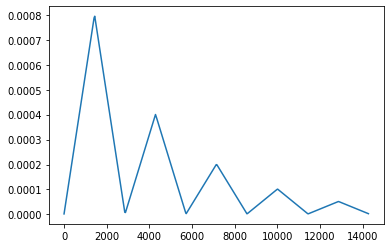

In [31]:
steps_per_epoch = int(np.ceil(len(train_paths)/BATCH_SIZE))
clr = tfa.optimizers.Triangular2CyclicalLearningRate(
            initial_learning_rate=CONFIG["min_lr"],
            maximal_learning_rate=CONFIG["max_lr"],
            step_size=CONFIG["clr_step_size"] * steps_per_epoch,
            scale_mode="cycle")
domain = range(0, 100*steps_per_epoch, 32)
lr_log = [clr(i).numpy() for i in domain]
plt.plot(domain, lr_log)
plt.show()

In [33]:
def get_wdc(op):
    lr = op.learning_rate
    wdc = CONFIG["weight_decay"]*lr/CONFIG["max_lr"]
    return wdc

initial_epoch = 0
clr_offset_ep = CONFIG["clr_offset_ep"]

def get_lr(op):
    lr = clr(op.iterations + (initial_epoch + clr_offset_ep)*steps_per_epoch)
    if tf.executing_eagerly():
        return lr.numpy()
    else:
        return lr

In [34]:
if CONFIG["optimizer"] == 'adamw':
    opt = tfa.optimizers.AdamW(learning_rate=lambda: clr, weight_decay=lambda : CONFIG["weight_decay"])
    # wd_schedule = tf.optimizers.schedules.ExponentialDecay(5e-5, 100, 0.9)    # weight_decay=lambda : None
    opt.learning_rate = lambda : get_lr(opt)
    if CONFIG["vary_weight_decay"]:
        opt.weight_decay = lambda : get_wdc(opt)
elif CONFIG["optimizer"] == 'adam':            # or just make weight_decay=0
    opt = tf.keras.optimizers.Adam(learning_rate=clr)
opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

In [35]:
if CONFIG["loss_function"] == 'FocalTversky':
    loss_function = FocalTversky()
elif CONFIG["loss_function"] == 'cce':
    loss_function = cce

In [78]:
model.compile(optimizer=opt, loss=loss_function, metrics=[dsc])

In [36]:
# model = tf.keras.models.load_model(wandb.restore("model-best.h5").name, custom_objects={'ConvNorm': ConvNorm,
#                                                                                         'NormAct': NormAct,
#                                                                                         'AttnBottleneckBlock': AttnBottleneckBlock,
#                                                                                         'BasicBlock': BasicBlock,
#                                                                                         'InvertedResBlock': InvertedResBlock,
#                                                                                         'SqueezeExcite': SqueezeExcite,
#                                                                                         'MHSA3D': MHSA3D,
#                                                                                         'AbsPosEmb': AbsPosEmb,
#                                                                                         'dsc': dsc,
#                                                                                         'FocalTversky': FocalTversky,
#                                                                                         })
# model.compile(optimizer=model.optimizer, loss=model.loss, metrics=[dsc])

In [37]:
wandb_cb = WandbCallback(monitor='dsc', mode='max')

In [38]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        img, lbl = next(iter(val_ds))
        pred = self.model(img)
        i = epoch % BATCH_SIZE
        img = img[i,1].numpy()
        mn = img.min()
        mx = img.max()
        img = (img - mn)/(mx - mn) * 255
        lbl = lbl[i,1:].numpy()*255
        pred = pred[i,1:].numpy()*255
        get_gif(img, lbl, pred, "out.gif")
        wandb.log({"Outputs": wandb.Image("out.gif")})
        gc.collect()

In [39]:
history = model.fit(train_ds,
                    epochs=100,
                    steps_per_epoch=np.ceil(len(train_paths)/BATCH_SIZE),
                    validation_data=val_ds,
                    validation_steps=np.ceil(len(val_paths)//BATCH_SIZE),
                    initial_epoch=initial_epoch,
                    workers=4,
                    use_multiprocessing=True,
                    callbacks=[CustomCallback(), wandb_cb])

Epoch 71/100
143/143 [==============================] - 312s 2s/step - loss: 1.1240 - dsc: 0.6943 - val_loss: 0.8114 - val_dsc: 0.7931
Epoch 72/100
143/143 [==============================] - 251s 2s/step - loss: 1.0584 - dsc: 0.7198 - val_loss: 0.8127 - val_dsc: 0.8108
Epoch 73/100
143/143 [==============================] - 248s 2s/step - loss: 1.0553 - dsc: 0.7247 - val_loss: 0.8145 - val_dsc: 0.8076
Epoch 74/100
143/143 [==============================] - 247s 2s/step - loss: 1.1230 - dsc: 0.6981 - val_loss: 0.7776 - val_dsc: 0.8112
Epoch 75/100
143/143 [==============================] - 249s 2s/step - loss: 1.0563 - dsc: 0.7225 - val_loss: 0.7660 - val_dsc: 0.8186
Epoch 76/100
143/143 [==============================] - 247s 2s/step - loss: 1.0381 - dsc: 0.7301 - val_loss: 0.8029 - val_dsc: 0.8062
Epoch 77/100
143/143 [==============================] - 245s 2s/step - loss: 1.0777 - dsc: 0.7173 - val_loss: 0.7782 - val_dsc: 0.8062
Epoch 78/100
143/143 [==============================] -

In [40]:
model.evaluate(val_ds, steps=np.ceil(len(val_paths)//BATCH_SIZE))

25/25 [==============================] - 19s 686ms/step - loss: 0.7436 - dsc: 0.8204


[0.7435517311096191, 0.8203723430633545]

In [41]:
scores = []
for i, (a,b) in tqdm(enumerate(train_ds)):
    if i==steps_per_epoch:
        break
    o = model(a)
    o = tf.cast(o, tf.float32)
    scores.append(dsc(b,o))

In [42]:
np.mean(scores, axis=0)

array([0.693558  , 0.72110546, 0.7894503 ], dtype=float32)

In [43]:
run.finish()

_step,209
_runtime,27434
best_dsc,0.74889
_timestamp,1621591503
dsc,0.73085
loss,1.02704
epoch,99
val_dsc,0.82037
val_loss,0.74355
best_epoch,91


_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,▇█▅▇▅▆▇▇▆▇▆▅▆▆▅▅▆▃▃▆▄▁▄▆▂▄▄▇▃▄
dsc,▂▁▄▂▄▃▂▂▄▂▂▄▃▃▄▃▃▆▆▃▅█▅▃▇▄▄▂▅▄
val_loss,███▄▃▇▄▇▂▅▄▅▆▃▃▂▄▆▂▄▃▇▅▁▅▅▁█▃▁
val_dsc,▂▅▅▅▇▄▄▂▇▄▆▂▃▄▃▇▅▂▅▇▃▃▃▇▅▅█▁▆▇
